In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.feature_selection import SelectKBest, f_classif  # ANOVA F-test for classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import tensorflow as tf
import os
from chirp.inference import tf_examples


2025-03-13 11:24:53.958814: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-13 11:24:53.966241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741865093.974387    8937 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741865093.976814    8937 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-13 11:24:53.986215: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
tfrecord_dir  = '/mnt/d/Uni/'

In [3]:
def list_files_in_folder(folder_path):
    """
    Returns a list of all files in the given folder path.

    Parameters:
    folder_path (str): The path to the folder.

    Returns:
    List[str]: A list of file names in the folder.
    """
    # Check if the folder path exists
    if not os.path.exists(folder_path):
        raise FileNotFoundError(f"The folder '{folder_path}' does not exist.")

    # List all files in the folder (excluding directories)
    files = [file for file in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, file))]

    return files


In [4]:
def read_embeddings_to_dataframe(tfrecord_files):
    """
    Read the embeddings from the TFRecord files and return them as a DataFrame.
    
    Parameters:
    tfrecord_files (list): List of paths to the TFRecord files.
    
    Returns:
    pd.DataFrame: DataFrame containing the embeddings and filenames.
    """
    # Initialize empty lists to store filenames and embeddings
    filenames = []
    embeddings = []

    # Loop through the list of TFRecord files
    for tfrecord_file in tfrecord_files:
        # Create a TFRecordDataset from the current TFRecord file
        ds = tf.data.TFRecordDataset(tfrecord_file)

        # Use the example parser from tf_examples to parse the embeddings
        parser = tf_examples.get_example_parser()
        ds = ds.map(parser)

        # Iterate through the dataset and extract filenames and embeddings
        for ex in ds.as_numpy_iterator():
            filename = ex['filename'].decode("utf-8")  # Decode the byte string
            embedding = ex['embedding'].flatten()  # Flatten the embedding for easier handling
            filenames.append(filename)
            embeddings.append(embedding)

    # Convert the embeddings list to a DataFrame
    df = pd.DataFrame(embeddings)
    
    # Add the filenames as a separate column
    df['filename'] = filenames

    # Reorder columns to have 'filename' first
    df = df[['filename'] + [col for col in df.columns if col != 'filename']]

    return df

In [5]:
def process_in_batches(tfrecord_files, batch_size):
    """
    Process TFRecord files in batches and return a single DataFrame with all the embeddings.
    
    Parameters:
    tfrecord_files (list): List of paths to the TFRecord files.
    batch_size (int): Number of files to process in each batch.
    
    Returns:
    pd.DataFrame: DataFrame containing the embeddings and filenames from all batches.
    """
    # Initialize an empty list to store the dataframes from each batch
    df_list = []
    
    # Loop over the files in batches
    for i in range(0, len(tfrecord_files), batch_size):
        # Select the current batch of files
        batch_files = tfrecord_files[i:i + batch_size]
        
        print(f"Processing batch {i//batch_size + 1}")
        
        # Process the current batch and get a DataFrame
        batch_df = read_embeddings_to_dataframe(batch_files)
        
        # Append the batch dataframe to the list
        df_list.append(batch_df)
    
    # Concatenate all batch dataframes into one
        final_df = pd.concat(df_list, ignore_index=True)
        
    return final_df

In [6]:
file_list = list_files_in_folder(tfrecord_dir)
if 'reduced_feature_embeddings.csv' in file_list:
    file_list.remove('reduced_feature_embeddings.csv')
if 'config.json' in file_list:
    file_list.remove('config.json')

In [7]:
tfrecord_files = [os.path.join(tfrecord_dir, f) for f in file_list]

In [8]:
tfrecord_files

['/mnt/d/Uni/embeddings-1741777571-00000-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00001-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00002-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00003-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00004-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00005-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00006-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00007-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00008-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00009-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00010-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00011-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00012-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00013-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00014-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00015-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00016-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00017-of-00100',
 '/mnt/d/Uni/embeddings-1741777571-00018-of-00100',
 '/mnt/d/Uni

In [10]:
embeddings_df = process_in_batches(tfrecord_files, batch_size=1)

Processing batch 1
Processing batch 2
Processing batch 3
Processing batch 4


2025-03-13 11:26:34.350765: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing batch 5
Processing batch 6
Processing batch 7
Processing batch 8
Processing batch 9
Processing batch 10
Processing batch 11
Processing batch 12


2025-03-13 11:28:41.817623: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Processing batch 13
Processing batch 14


: 

In [ ]:
df = embeddings_df
df

,filename,0,1,2,3,4,5,6,7,8,...,15350,15351,15352,15353,15354,15355,15356,15357,15358,15359
0,D1_M3/20211023_162400.WAV,0.031133,0.155440,-0.026822,0.098067,0.066278,0.247261,0.044280,0.009186,0.013526,...,-0.006468,-0.056042,-0.004049,-0.010680,-0.018316,0.014716,-0.163421,-0.001760,-0.077742,-0.012701
1,D1_M3/20211023_230400.WAV,-0.064481,0.004292,-0.083554,0.041118,-0.019286,0.212815,0.009370,0.065651,-0.061030,...,-0.001610,-0.005652,-0.088140,-0.000125,-0.010410,0.067016,-0.154588,0.010973,-0.022688,0.005367
2,D1_M3/20211024_054400.WAV,-0.007432,-0.020471,-0.095617,0.013205,-0.061797,0.234267,-0.051408,0.136250,-0.029666,...,-0.019575,-0.034039,-0.078502,0.040115,0.027141,0.073500,-0.013658,0.001793,0.076455,-0.012596
3,D1_M3/20211024_122400.WAV,-0.013618,0.017437,-0.130425,0.120752,-0.082031,0.234639,0.032860,0.023693,-0.001192,...,-0.006249,-0.042201,-0.085565,-0.073821,-0.011553,0.021410,-0.045348,-0.011395,-0.044730,0.043920
4,D1_M3/20211024_190400.WAV,-0.147071,0.063163,-0.118910,0.300446,-0.111755,0.237845,-0.008012,-0.002486,-0.066270,...,0.033965,-0.115695,-0.105165,-0.081363,-0.008499,-0.003733,-0.094005,0.005953,0.041895,0.021825
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58497,R1_M6/20211124_082000.WAV,-0.002302,-0.019382,-0.086418,0.113302,-0.155693,0.200797,-0.030490,0.106350,-0.023731,...,-0.004960,-0.082498,-0.155121,-0.035795,-0.009247,0.013206,-0.158153,-0.003255,-0.045118,0.039227
58498,R1_M6/20211124_150000.WAV,-0.084707,0.053093,-0.074226,-0.052951,-0.162178,0.221737,0.004094,0.112219,0.016298,...,-0.015027,-0.144407,-0.088282,-0.055596,0.034359,0.003885,-0.007395,0.032403,-0.032912,0.009658
58499,R1_M6/20211124_214000.WAV,-0.039748,0.021920,-0.145149,-0.124404,-0.139002,0.263311,-0.005866,0.032738,-0.034543,...,-0.001055,-0.065903,-0.089177,-0.055773,0.003268,0.017803,-0.190916,0.014890,-0.027967,0.022288
58500,R1_M6/20211125_042000.WAV,-0.046708,-0.027570,-0.080697,-0.104624,-0.140113,0.232693,0.006947,0.231593,-0.059060,...,0.011023,-0.070679,-0.118329,-0.051991,0.016713,0.061042,-0.196130,0.003903,-0.062380,0.034681


In [ ]:
def extract_metadata_from_filename(file):
    # Split the filename using '_' as the delimiter
    parts = file.split('_')
    
    # Extract the first part (before the first '_')
    first_part = parts[0] if len(parts) > 0 else ""
    
    # Return only the first letter of the first part
    return first_part[0] if first_part else ""


# Applying the function to each filename in the DataFrame
df['class_type'] = df['filename'].apply(extract_metadata_from_filename)

In [ ]:
df

,filename,0,1,2,3,4,5,6,7,8,...,15351,15352,15353,15354,15355,15356,15357,15358,15359,class_type
0,D1_M3/20211023_162400.WAV,0.031133,0.155440,-0.026822,0.098067,0.066278,0.247261,0.044280,0.009186,0.013526,...,-0.056042,-0.004049,-0.010680,-0.018316,0.014716,-0.163421,-0.001760,-0.077742,-0.012701,D
1,D1_M3/20211023_230400.WAV,-0.064481,0.004292,-0.083554,0.041118,-0.019286,0.212815,0.009370,0.065651,-0.061030,...,-0.005652,-0.088140,-0.000125,-0.010410,0.067016,-0.154588,0.010973,-0.022688,0.005367,D
2,D1_M3/20211024_054400.WAV,-0.007432,-0.020471,-0.095617,0.013205,-0.061797,0.234267,-0.051408,0.136250,-0.029666,...,-0.034039,-0.078502,0.040115,0.027141,0.073500,-0.013658,0.001793,0.076455,-0.012596,D
3,D1_M3/20211024_122400.WAV,-0.013618,0.017437,-0.130425,0.120752,-0.082031,0.234639,0.032860,0.023693,-0.001192,...,-0.042201,-0.085565,-0.073821,-0.011553,0.021410,-0.045348,-0.011395,-0.044730,0.043920,D
4,D1_M3/20211024_190400.WAV,-0.147071,0.063163,-0.118910,0.300446,-0.111755,0.237845,-0.008012,-0.002486,-0.066270,...,-0.115695,-0.105165,-0.081363,-0.008499,-0.003733,-0.094005,0.005953,0.041895,0.021825,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58497,R1_M6/20211124_082000.WAV,-0.002302,-0.019382,-0.086418,0.113302,-0.155693,0.200797,-0.030490,0.106350,-0.023731,...,-0.082498,-0.155121,-0.035795,-0.009247,0.013206,-0.158153,-0.003255,-0.045118,0.039227,R
58498,R1_M6/20211124_150000.WAV,-0.084707,0.053093,-0.074226,-0.052951,-0.162178,0.221737,0.004094,0.112219,0.016298,...,-0.144407,-0.088282,-0.055596,0.034359,0.003885,-0.007395,0.032403,-0.032912,0.009658,R
58499,R1_M6/20211124_214000.WAV,-0.039748,0.021920,-0.145149,-0.124404,-0.139002,0.263311,-0.005866,0.032738,-0.034543,...,-0.065903,-0.089177,-0.055773,0.003268,0.017803,-0.190916,0.014890,-0.027967,0.022288,R
58500,R1_M6/20211125_042000.WAV,-0.046708,-0.027570,-0.080697,-0.104624,-0.140113,0.232693,0.006947,0.231593,-0.059060,...,-0.070679,-0.118329,-0.051991,0.016713,0.061042,-0.196130,0.003903,-0.062380,0.034681,R


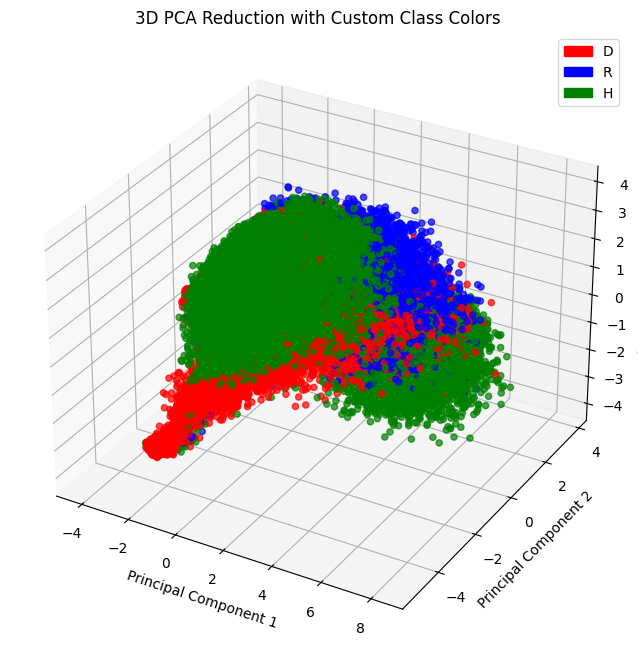

''

In [ ]:
# If using a Jupyter Notebook in VS Code, uncomment the following line:
# %matplotlib widget

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib.patches as mpatches
import pandas as pd

# If running as a script, enable interactive mode:
plt.ion()

# Assuming embeddings_df is already defined and contains your data
# Extract feature columns (exclude non-numeric columns like 'filename' and 'class_type')
feature_columns = [col for col in embeddings_df.columns if col not in ['filename', 'class_type']]
X = embeddings_df[feature_columns]

# Reduce dimensions to 3 using PCA
pca = PCA(n_components=3)
pca_features = pca.fit_transform(X)

# Add the PCA components to the DataFrame
embeddings_df['pca1'] = pca_features[:, 0]
embeddings_df['pca2'] = pca_features[:, 1]
embeddings_df['pca3'] = pca_features[:, 2]

# Define a mapping of class types to specific colors
color_mapping = {
    'D': 'red',
    'R': 'blue',
    'H': 'green'
}
colors = embeddings_df['class_type'].map(color_mapping)

# Create an interactive 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(embeddings_df['pca1'], embeddings_df['pca2'], embeddings_df['pca3'], 
                     c=colors, alpha=0.7)

ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
ax.set_title('3D PCA Reduction with Custom Class Colors')

# Create a legend for the class types
patches = [mpatches.Patch(color=color, label=cls) for cls, color in color_mapping.items()]
ax.legend(handles=patches)

plt.show()

# If running as a script, you might want to keep the window open:
input("Press [enter] to close the plot...")



In [ ]:
k = 5  
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
all_predictions = []
all_true_labels = []

In [ ]:
for train_index, test_index in kf.split(X):
    # Split data into training and testing folds
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # **Step 2a: Feature Selection using ANOVA F-test**
    selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)  # Apply same selection to test data

    # **Step 2b: Train the Classifier**
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train_selected, y_train)

    # **Step 2c: Predict on Fold k**
    y_pred = clf.predict(X_test_selected)

    # Store results
    all_predictions.extend(y_pred)
    all_true_labels.extend(y_test)

# Evaluate overall performance
accuracy = accuracy_score(all_true_labels, all_predictions)
print(f"Cross-validated Accuracy: {accuracy:.4f}")

NameError: name 'y' is not defined